In [ ]:
                                                # IMPORTING LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import os
import ccxt
import datetime as dt
import seaborn as sns
import yfinance as yf

                                                    # CREATING THE RESULTS DIRECTORY FOR THE PROBLEMS SETS 
results_dir='RESULTS_WEEK_2'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)



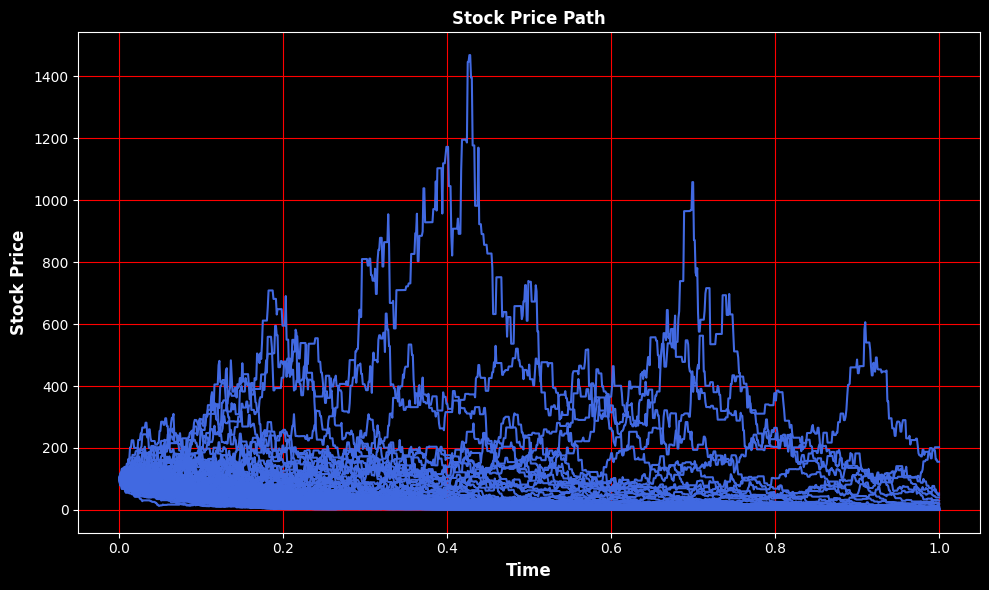

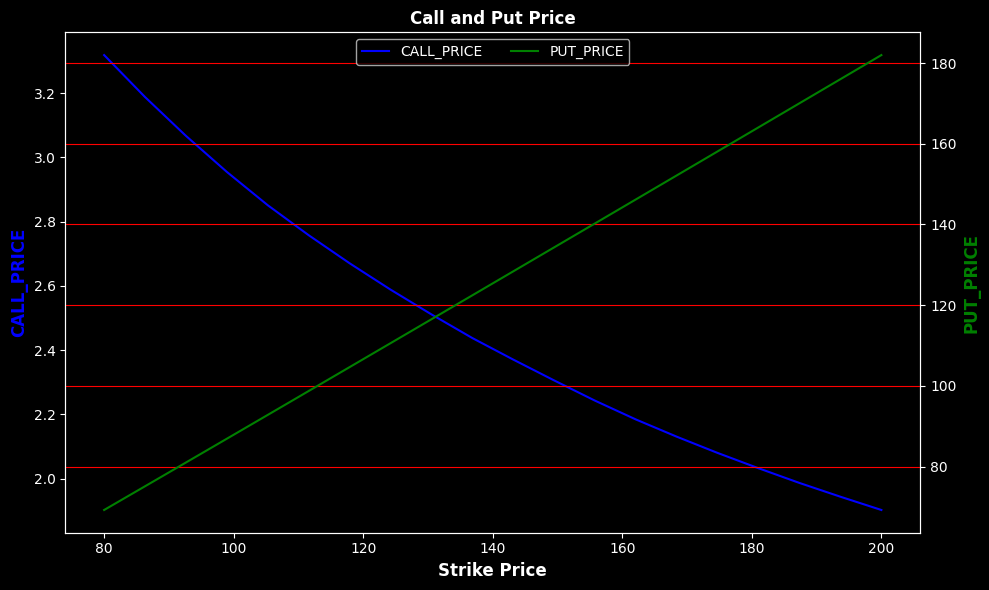

In [ ]:
                                    # DAY 1 MERTON JUMP MODEL WITH POISSON JUMPS AND MONTE CARLO PRICING FOR OPTIONS
        
                                    
                                        # INITIALIZING THE IMPORTANT PARAMTERS 
S_0=100                                 # INITIAL STOCK PRICE
RISK_FREE_RATE=0.05                     # 5% RISK FREE T_BILL RATE
VOLATILITY_STOCK=0.20                   # VOLATILITY OF STOCK
STRIKES=np.linspace(80,200,20)          # STRIKE VALUES
DURATION=1                              # TIME TO Maturity
Nofpaths=10000                          # NUMBER OF PATHS
Nofsteps=1000                           # Number of time steps
LAMBDA=0.5                              # poisson jump intensity
JUMP_MEAN=-0.0108                       # JUMP MAGNITUDE MEAN
JUMP_VOLATILTITY=0.10                   # JUMP MAGNITUDE VOLAITILTY
PRICES=pd.DataFrame(index=STRIKES)      # STRIKE PRICE DATAFRAME
day_result='JUMP_DIFFUSION_MERTON_MODEL'

''' MODEL CHARACTERISTICS
1) THE JUMP FOLLOWS THE POSSION INDICATOR PROCESS 
2) THE JUMP SIZE IS A RANDOM NORMAL  VARIABLE WITH A GIVEN MEAN AND VOLATILITY
3) THE JUMP SIZE IS NOT CORRELATED WITH THE STOCK PRICE MOVEMENTS
4) THE VOLATILITY AND THE JUMP PARAMTERS AND NON STOCHASTIC 
5) THE METHOD FOR PATH GENERATION WILL BE EULER DISCRETISATION
6) THE JUMP PARAMETERS ARE SET TO SIMULATE STOCK CRASH SCENARIOS
'''
                                            # CREATE THE RESULTS DIRECTORY CONCATENATED WITHE MAIN RESULTS DIRECTPRY
fold_path=os.path.join(results_dir,day_result)
if not os.path.exists(fold_path):
    os.makedirs(fold_path)

                                            # PATH GENERATION FUNCTION


def Path_Generation(INITIAL_STOCK,RISK_FREE_RATE,VOLATILITY_STOCK,DURATION,LAMBDA,JUMP_MEAN,JUMP_VOLATILTITY,Nofsteps,Nofpaths):
    STOCK_PATHS=np.zeros((Nofpaths,Nofsteps+1))
    z=np.random.randn(Nofpaths,Nofsteps)
    STOCK_PATHS[:,0]=INITIAL_STOCK
    dt=DURATION/Nofsteps
    poisson=np.random.poisson(LAMBDA,size=(Nofpaths,Nofsteps))
    poisson=np.where(poisson>0,1,0)
    jump_mag=np.random.normal(JUMP_MEAN,JUMP_VOLATILTITY,size=(Nofpaths,Nofsteps))
    time=[i*dt for i in range(Nofsteps+1)]
    PARAMTERS={}
    for I in range(Nofsteps):
        z[:,I]=(z[:,I]-np.mean(z[:,I]))/(np.std(z[:,I]))
        STOCK_PATHS[:,I+1]=STOCK_PATHS[:,I] + STOCK_PATHS[:,I]*(RISK_FREE_RATE-LAMBDA*np.mean(jump_mag[:,I]))*dt + VOLATILITY_STOCK*z[:,I]*np.sqrt(dt) + STOCK_PATHS[:,I]*(np.exp(jump_mag[:,I])-1)*poisson[:,I]
        STOCK_PATHS[:,I+1]=np.maximum(STOCK_PATHS[:,I+1],0)
        
    PARAMTERS['PATHS']=STOCK_PATHS
    PARAMTERS['TIME']=time
    PARAMTERS['POISSON_MATRIX']=poisson
    PARAMTERS['JUMP_MAGNITUDE_MATRIX']=jump_mag
    PARAMTERS['STOCK_MATURITY']=STOCK_PATHS[:,-1]
    return PARAMTERS

                                            #INITIALISING THE STOCK PATHS AND TIME STAMPS AND STORING THEM UN THE PARATERS VARIABLE TO AVOID LOOPING AND COMPUATATIONAL TIME 

parameters=Path_Generation(S_0,RISK_FREE_RATE,VOLATILITY_STOCK,DURATION,LAMBDA,JUMP_MEAN,JUMP_VOLATILTITY,Nofsteps,Nofpaths)



                                            # DEFINING THE MONTE CARLO PRICING FUNCTION
def monte_carlo_pricing(type,INITIAL_STOCK,STRIKE,RISK_FREE_RATE,VOLATILITY_STOCK,DURATION,LAMBDA,JUMP_MEAN,JUMP_VOLATILTITY,Nofsteps,Nofpaths,parameters):
     
     S_T=parameters['STOCK_MATURITY']
     type=type.lower()
     if type=='call':
         price=np.exp(-RISK_FREE_RATE*DURATION)*np.mean(np.maximum(S_T-STRIKE,0))
     elif type=='put':
        price=np.exp(-RISK_FREE_RATE*DURATION)*np.mean(np.maximum(STRIKE-S_T,0))
     return price
    
PRICES['CALL_PRICE']=[monte_carlo_pricing('call',S_0,strike,RISK_FREE_RATE,VOLATILITY_STOCK,DURATION,LAMBDA,JUMP_MEAN,JUMP_VOLATILTITY,Nofsteps,Nofpaths,parameters) for strike in STRIKES]
PRICES['PUT_PRICE']=[monte_carlo_pricing('put',S_0,strike,RISK_FREE_RATE,VOLATILITY_STOCK,DURATION,LAMBDA,JUMP_MEAN,JUMP_VOLATILTITY,Nofsteps,Nofpaths,parameters) for strike in STRIKES]
PRICES.index.name='STRIKE PRICE'
FILE_PATH=os.path.join(fold_path,'MERTON_JUMP_MODEL_PRICES.csv')
PRICES.to_csv(FILE_PATH)



                                                # PLOTTING THE STOCK PATHS AND THE CALL AND PUT PRICES

                                               
                                               
                                               
                                                # plotting the simulated stock price paths  first 100 sample paths
PARAMETERS=Path_Generation(S_0,RISK_FREE_RATE,VOLATILITY_STOCK,DURATION,LAMBDA,JUMP_MEAN,JUMP_VOLATILTITY,Nofsteps,Nofpaths)
PATHS=PARAMETERS['PATHS']
TIME=PARAMETERS['TIME']

fig,ax=plt.subplots(figsize=(10,6))
plt.style.use('dark_background')

for i in range(100):
    ax.plot(TIME,PATHS[i,:],color='royalblue')   
ax.set_xlabel('Time',fontdict={'weight':'bold','size':12})
ax.set_ylabel('Stock Price',fontdict={'weight':'bold','size':12})
ax.set_title('Stock Price Path',fontdict={'weight':'bold','size':12})

plt.grid(True,color='r',linestyle='-')
fig_path=os.path.join(fold_path,'MERTON_JUMP_MODEL_STOCK_PATHS.png')
plt.tight_layout()
plt.savefig(fig_path,bbox_inches='tight',dpi=300)
plt.show()

                                                
                                                
                                                
                                                # plotting the call and put prices
fig,ax=plt.subplots(figsize=(10,6))
plt.style.use('dark_background')

ax.plot(STRIKES,PRICES['CALL_PRICE'],color='blue',label='CALL_PRICE')
ax.set_xlabel('Strike Price',fontdict={'weight':'bold','size':12})
ax.set_ylabel('CALL_PRICE',fontdict={'weight':'bold','size':12},color='blue')


ax1=ax.twinx()
ax1.plot(STRIKES,PRICES['PUT_PRICE'],color='GREEN',label='PUT_PRICE')
ax1.set_ylabel('PUT_PRICE',fontdict={'weight':'bold','size':12},color='green')

lines1,labels1= ax.get_legend_handles_labels()
lines2,labels2= ax1.get_legend_handles_labels()
ax1.legend(lines1+lines2,labels1+labels2,loc='upper center',frameon=True,ncol=2,fontsize=10)


plt.title('Call and Put Price',fontdict={'weight':'bold','size':12})
plt.grid(True,color='r',linestyle='-')


fig_path=os.path.join(fold_path,'MERTON_JUMP_MODEL_CALL_PUT_PRICES.png')

plt.tight_layout()
plt.savefig(fig_path,bbox_inches='tight',dpi=300)
plt.show()
                                                                        

